# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings. The underlying question of the project is that how can Arvato acquire new clients efficiently ?

In [84]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

# magic word for producing visualizations in notebook
%matplotlib inline


In [85]:
#Functions developed during the process and used from part 2 onwards of the project

def missing_val_cols():

    '''
    INPUT: none
    
    OUTPUT:returns a list of columns from attribute file which have NaN encoded as 0,-1,10 0
    
    Description: returns a list of columns from attribute file which have NaN encoded as 0,-1,10 0
    
    '''
    #reading attribute file
    attribute_file = pd.read_excel('DIAS_Attributes_Values_2017.xlsx', sheet_name='Tabelle1', header=1)
    #applying forward filling to fill na
    attribute_file.fillna(method='ffill',axis=0,inplace=True)
    # Dropping the 'Unnnamed:0' column
    attribute_file.drop(labels=['Unnamed: 0'],axis=1,inplace=True)
    #filtering columns which have NaN encoded as 0,-1,10 0
    missingval_cols = attribute_file.query("Meaning == 'unknown' or Meaning == 'unknown / no main age detectable' or Meaning == 'no transaction known' or Meaning == 'no transactions known'").iloc[:,0].tolist()

    return missingval_cols


def clean_data(df):
    '''
    INPUT: data frame
            
    OUTPUT: cleaned data frame
    
    Description: Performs data cleansing steps and encoding NaN 
    
    '''
    missingval_cols = missing_val_cols() 
    
    #Updating filtered columns of data frame with missing values coded as 0,-1,9,10 to NaN 
    col_list = df.columns.tolist()  #list of df columns
    cols_updated = list(set(missingval_cols).intersection(set(col_list)))  
    df.loc[:,cols_updated] = df.loc[:,cols_updated].replace(to_replace=[0,0.0,-1,-1.0,9,9.0,10,10.0], value= np.nan)

    #Replacing 0 / 0.0 with np.nan for numerical columns    
    num_cols = ['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','GEBURTSJAHR','KBA13_ANZAHL_PKW','MIN_GEBAEUDEJAHR']
    df.loc[:,num_cols] = df.loc[:,num_cols].replace(to_replace=[0,0.0], value= np.nan)
    
    #removing CAMEO_DEU_2015, below is not required
    # replace XX to nan for CAMEO_DEU_2015
    #df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace(to_replace=['XX'], value= np.nan)
    
    # replace X to nan and changing data type to numeric
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace(to_replace=['X'], value= np.nan)
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].apply(pd.to_numeric, errors='coerce')
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace(to_replace=['XX'], value= np.nan)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].apply(pd.to_numeric, errors='coerce')
    
    #dropping EINGEFUEGT_AM
    df = df.drop('EINGEFUEGT_AM',axis=1)
    
    #Attempt to improve model, dropping these two columns as they would increase sparsity by adding more columns
    df = df.drop('CAMEO_DEU_2015',axis=1)
    df = df.drop('D19_LETZTER_KAUF_BRANCHE',axis=1)
    
    #0.0 is not a valid value in LP_FAMILIE_GROB description. Replacing it with np.nan
    df.loc[:,'LP_FAMILIE_GROB'] = df.loc[:,'LP_FAMILIE_GROB'].replace(to_replace=[0.0], value= np.nan)
    
    #dropping any columns with all '0' values as no value would be added by them
    df = df.loc[:, (df != 0).any(axis=0)]

    return df



In [86]:
#Functions part 2

def drop_null_cols_vals(df):
    
    '''
    INPUT: 
    data frame
    
    OUTPUT: data frame with reduced dimensions/values, list of columns to be dropped
    
    Description: drops columns with > 30% NAN and rows with all NAN
    
    '''
    #dropping columns with > 30% NAN 
    missing_vals = df.isna().mean() 
    missing_vals = pd.DataFrame(missing_vals[missing_vals > 0.3])   # dropping cols with > 30% NAN
    #missing_vals = pd.DataFrame(missing_vals[missing_vals > 0.2])    # dropping cols with > 20% NAN
    cols_drop = missing_vals.index.tolist()
    df = df.drop(cols_drop,axis=1)
    
    #Dropping rows with all NAN
    df = df.dropna(how='all')

    return df, cols_drop


def encode_cat_vars(df):
    
    '''
    INPUT: data frame
            
    OUTPUT: cleaned data frame with dummy variables for indentified categorical variable
    
    Description: encodes dummy variables for CAMEO_DEU_2015, D19_LETZTER_KAUF_BRANCHE & OST_WEST_KZ columns
    
    '''

    # removing CAMEO_DEU_2015, D19_LETZTER_KAUF_BRANCHE, below is not required
    #Encoding dummy variables for CAMEO_DEU_2015
    #df = pd.get_dummies(df, prefix='CAMEO_DEU_2015', columns=['CAMEO_DEU_2015'],drop_first=True)
    #Encoding dummy variables for D19_LETZTER_KAUF_BRANCHE
    #df = pd.get_dummies(df, columns=['D19_LETZTER_KAUF_BRANCHE'], prefix='LETZTER_KAUF_BRANCHE', drop_first=True)
    
    #Replacing 'W','O' with 1 and 0 in OST_WEST_KZ
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace(to_replace=['W','O'], value=[1,0])
    
    return df    

In [87]:
#Functions part 3

# Function to load training data and split it to dependent/independent variables
def load_data():
    
    '''
    INPUT: data frame
            
    OUTPUT: X (an array of predictor variables), y (an array of response variables)
    
    Description: Loads training data and split it to dependent/independent variables
    
    '''
    
    mailout_train_clean = pd.read_csv('mailout_train.csv')
     
    X = mailout_train_clean.drop(['LNR','RESPONSE'], axis=1).copy().values  #removing LNR and RESPONSE columns
    y = mailout_train_clean['RESPONSE'].copy().values
    
    
    return X,y  



## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Loading and inspecting the general population and customers data

In [74]:
#load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\Administrator\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [75]:
#Inspecting general population data in the next few columns including missing values
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [76]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [77]:
#Inspecting missing values
azdias.isna().sum()

LNR                          0
AGER_TYP                     0
AKT_DAT_KL               73499
ALTER_HH                 73499
ALTER_KIND1             810163
                         ...  
WOHNDAUER_2008           73499
WOHNLAGE                 93148
ZABEOTYP                     0
ANREDE_KZ                    0
ALTERSKATEGORIE_GROB         0
Length: 366, dtype: int64

In [78]:
#Inspecting duplicate rows
azdias[azdias.duplicated()]

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB


In [79]:
#Inspecting customers data in the next few columns including missing values
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [80]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [81]:
customers.isna().sum()

LNR                          0
AGER_TYP                     0
AKT_DAT_KL               46596
ALTER_HH                 46596
ALTER_KIND1             179886
                         ...  
PRODUCT_GROUP                0
CUSTOMER_GROUP               0
ONLINE_PURCHASE              0
ANREDE_KZ                    0
ALTERSKATEGORIE_GROB         0
Length: 369, dtype: int64

In [82]:
#Inspecting duplicate rows
customers[customers.duplicated()]

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB


## Reading attribute file to filter columns for various missing values in the general population data and replaceing them with NaN

In [83]:
# attribute file indicates certain categorical columns in azdias data have NaN encoded as 0,-1,10, 0.
# Meaning for above encoding is: unknown / no main age detectable, unknown, no transaction known,no transactions known 
# Reading attribute file 
attribute_file = pd.read_excel('DIAS_Attributes_Values_2017.xlsx', sheet_name='Tabelle1', header=1)
attribute_file.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [84]:
#applying forward filling to fill na
attribute_file.fillna(method='ffill',axis=0,inplace=True)
# Dropping the 'Unnnamed:0' column
attribute_file.drop(labels=['Unnamed: 0'],axis=1,inplace=True)
attribute_file.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [85]:
# Filter rows with Meaning as follows for no/missing values:
# unknown / no main age detectable, unknown, no transaction known,no transactions known 

missingval_cols = attribute_file.query("Meaning == 'unknown' or Meaning == 'unknown / no main age detectable' or Meaning == 'no transaction known' or Meaning == 'no transactions known'").iloc[:,0].tolist()

#Updating filtered columns with missing values coded as 0,-1,9,10 to NaN 
col_list = azdias.columns.tolist()  #list of azdias columns
cols_updated = list(set(missingval_cols).intersection(set(col_list)))  
azdias.loc[:,cols_updated] = azdias.loc[:,cols_updated].replace(to_replace=[0,0.0,-1,-1.0,9,9.0,10,10.0], value= np.nan)


In [86]:
#Inspecting the data
azdias.iloc[1:10,:]

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,NaN,4.0,5,2,1.0
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,NaN,2.0,5,2,3.0
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,NaN,7.0,3,2,4.0
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,NaN,3.0,4,1,3.0
5,910244,3.0,1.0,NaN,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,NaN,7.0,4,2,1.0
6,910248,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,NaN,5.0,4,2,2.0
7,910261,NaN,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,NaN,1.0,1,1,1.0
8,645145,NaN,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3.0
9,645153,NaN,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3.0


## Inspecting numerical columns

In [87]:
# Inspecting numercial columns for the general population data
num_cols = ['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','GEBURTSJAHR','KBA13_ANZAHL_PKW','MIN_GEBAEUDEJAHR']
azdias[num_cols]

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,GEBURTSJAHR,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR
0,NaN,NaN,NaN,NaN,0,NaN,NaN
1,11.0,0.0,2.0,0.0,1996,963.0,1992.0
2,10.0,0.0,1.0,0.0,1979,712.0,1992.0
3,1.0,0.0,0.0,0.0,1957,596.0,1997.0
4,3.0,0.0,4.0,0.0,1963,435.0,1992.0
...,...,...,...,...,...,...,...
891216,15.0,0.0,1.0,0.0,1976,282.0,1992.0
891217,11.0,0.0,1.0,0.0,1970,592.0,1992.0
891218,3.0,0.0,0.0,0.0,1976,688.0,1992.0
891219,7.0,0.0,1.0,0.0,1994,134.0,1992.0


In [88]:
#The description for the above numerical columns from attribute file appears to indicate value of 0 for them indicates no value 
# recorded or no information available. Therefore replacing 0 / 0.0 with np.nan for numerical columns

azdias.loc[:,num_cols] = azdias.loc[:,num_cols].replace(to_replace=[0,0.0], value= np.nan)
#Inspecting the first five rows
azdias[num_cols].iloc[0:5,:]

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,GEBURTSJAHR,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11.0,NaN,2.0,NaN,1996.0,963.0,1992.0
2,10.0,NaN,1.0,NaN,1979.0,712.0,1992.0
3,1.0,NaN,NaN,NaN,1957.0,596.0,1997.0
4,3.0,NaN,4.0,NaN,1963.0,435.0,1992.0


In [89]:
#Describing the numerical columns
azdias[num_cols].describe()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,GEBURTSJAHR,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR
count,791610.000000,23969.000000,783619.000000,3180.000000,498903.000000,785359.000000,798073.000000
mean,8.354924,1.346823,1.802824,1.070126,1967.102689,619.750361,1993.277011
std,15.673731,1.311438,1.121865,0.280072,17.795208,340.003155,3.332739
min,1.000000,1.000000,1.000000,1.000000,1900.000000,1.000000,1985.000000
25%,2.000000,1.000000,1.000000,1.000000,1955.000000,384.000000,1992.000000
50%,4.000000,1.000000,1.000000,1.000000,1968.000000,549.000000,1992.000000
75%,10.000000,1.000000,2.000000,1.000000,1981.000000,778.000000,1993.000000
max,595.000000,23.000000,45.000000,6.000000,2017.000000,2300.000000,2016.000000


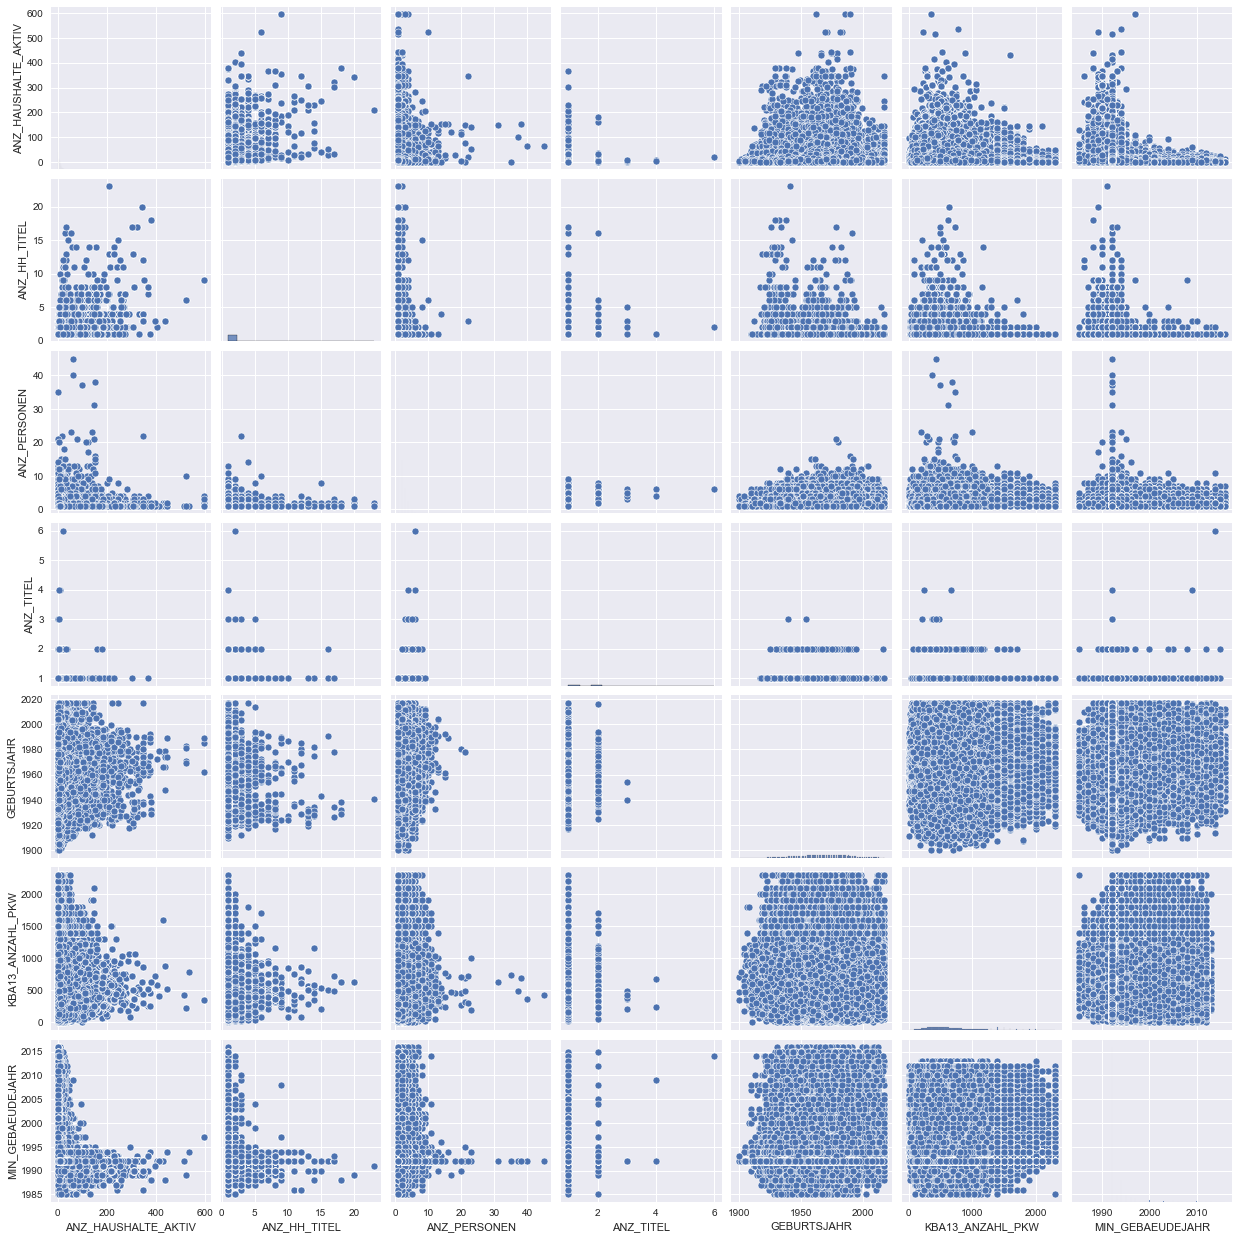

In [90]:
#pairplot for numerical columns to inspect their distributions
sns.pairplot(azdias[num_cols], diag_kind='hist',dropna=True);

## Inspecting and cleaning obj columns

In [91]:
# checking object dtype columns
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(297), int64(63), object(6)
memory usage: 2.4+ GB


In [92]:
# Inspecting object data type columns
obj_cols = azdias.select_dtypes(include=['object']).columns.tolist()
azdias[obj_cols][0:10]

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
5,8C,8,54,D19_ENERGIE,1992-02-12 00:00:00,W
6,4A,4,22,D19_UNBEKANNT,1992-02-12 00:00:00,W
7,2D,2,14,D19_UNBEKANNT,1992-02-10 00:00:00,W
8,1A,1,13,NaN,1992-02-10 00:00:00,W
9,1E,1,15,D19_KOSMETIK,1992-02-10 00:00:00,W


In [93]:
# CAMEO_DEU_2015 is a categorical column and has XX for missing values
print(azdias.CAMEO_DEU_2015.value_counts())
# replace XX to nan
azdias['CAMEO_DEU_2015'].replace(to_replace=['XX'], value= np.nan, inplace=True)

6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
XX      373
Name: CAMEO_DEU_2015, dtype: int64


In [94]:
# CAMEO_DEUG_2015 is a categorical variable (ordinal) with a mix of int and float values and has X for missing values
print(azdias.CAMEO_DEUG_2015.value_counts())
# replace X to nan
azdias['CAMEO_DEUG_2015'].replace(to_replace=['X'], value= np.nan, inplace=True)
# changing data type to numeric
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].apply(pd.to_numeric, errors='coerce')

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64


In [95]:
# CAMEO_INTL_2015 is a categorical variable (nominal) with mix of int and float and X
print(azdias.CAMEO_INTL_2015.value_counts())
# replace X to nan
azdias['CAMEO_INTL_2015'].replace(to_replace=['XX'], value= np.nan, inplace=True)
#changing data type to numeric
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].apply(pd.to_numeric, errors='coerce')

51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0     7983
34.0     7787
12       7645
15.0     7142
44.0     6277
35       6090
32       6067
33       5833
12.0     5604
32.0     4287
35.0     4266
33.0     4102
XX        373
Name: CAMEO_INTL_2015, dtype: int64


In [96]:
# There do not appear to be any alternate encoding for missing values with this column
azdias.D19_LETZTER_KAUF_BRANCHE.value_counts()

D19_UNBEKANNT             195338
D19_VERSICHERUNGEN         57734
D19_SONSTIGE               44722
D19_VOLLSORTIMENT          34812
D19_SCHUHE                 32578
D19_BUCH_CD                28754
D19_VERSAND_REST           26034
D19_DROGERIEARTIKEL        24072
D19_BANKEN_DIREKT          23273
D19_BEKLEIDUNG_REST        21796
D19_HAUS_DEKO              20858
D19_TELKO_MOBILE           14447
D19_ENERGIE                12084
D19_TELKO_REST             11472
D19_BANKEN_GROSS           10550
D19_BEKLEIDUNG_GEH         10272
D19_KINDERARTIKEL           7301
D19_FREIZEIT                7257
D19_TECHNIK                 7002
D19_LEBENSMITTEL            6458
D19_BANKEN_REST             5247
D19_RATGEBER                4931
D19_NAHRUNGSERGAENZUNG      4061
D19_DIGIT_SERV              3577
D19_REISEN                  3122
D19_TIERARTIKEL             2578
D19_SAMMELARTIKEL           2443
D19_HANDWERK                2227
D19_WEIN_FEINKOST           2164
D19_GARTEN                  1646
D19_BANKEN

In [97]:
#inspecting EINGEFUEGT_AM column and its max/min values  
print(azdias.EINGEFUEGT_AM.dropna().sort_values())
print(azdias.EINGEFUEGT_AM.isnull().sum())

194542    1991-06-17 00:00:00
169369    1991-08-30 00:00:00
68153     1991-08-30 00:00:00
488410    1992-02-10 00:00:00
488409    1992-02-10 00:00:00
                 ...         
220795    2016-05-02 00:00:00
641000    2016-05-02 00:00:00
470993    2016-05-02 00:00:00
390125    2016-05-02 00:00:00
104621    2016-05-09 00:00:00
Name: EINGEFUEGT_AM, Length: 798073, dtype: object
93148


In [98]:
# This column appear to be data entry recording time with multiple entries with a broad
# range for a single date from 1991 to 2016 (EINGEFUEGT translates to inserted). It also has high number of missing values (>10%).
#Therefore dropping this column.
# as this also 
print(azdias.EINGEFUEGT_AM.value_counts())
azdias.drop('EINGEFUEGT_AM',axis=1,inplace=True)

1992-02-10 00:00:00    383738
1992-02-12 00:00:00    192264
1995-02-07 00:00:00     11181
2005-12-16 00:00:00      6291
2003-11-18 00:00:00      6050
                        ...  
2003-08-31 00:00:00         1
2011-06-17 00:00:00         1
1999-04-26 00:00:00         1
2006-12-31 00:00:00         1
2015-07-20 00:00:00         1
Name: EINGEFUEGT_AM, Length: 5162, dtype: int64


In [99]:
# OST_WEST_KZ is a categorical variable, there does not appear to be any separate encoding for missing values
azdias.OST_WEST_KZ.value_counts()

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

In [100]:
# Attribute values file indicate there may be multiple values for each type for the below coumns. 
# However the below output indicates they have been encoded correctly, so no changes are required
print(azdias['LP_FAMILIE_GROB'].value_counts())
print(azdias['LP_STATUS_GROB'].value_counts())

1.0    426379
5.0    200780
2.0    104305
0.0     72938
4.0     52784
3.0     29181
Name: LP_FAMILIE_GROB, dtype: int64
1.0    337511
2.0    226915
4.0    162946
5.0    118022
3.0     40973
Name: LP_STATUS_GROB, dtype: int64


In [101]:
# 0.0 is not a valid value in LP_FAMILIE_GROB description. Therefore replacing it with np.nan
azdias.loc[:,'LP_FAMILIE_GROB'] = azdias.loc[:,'LP_FAMILIE_GROB'].replace(to_replace=[0.0], value= np.nan)
print(azdias['LP_FAMILIE_GROB'].value_counts())

1.0    426379
5.0    200780
2.0    104305
4.0     52784
3.0     29181
Name: LP_FAMILIE_GROB, dtype: int64


## Visualizing columns with missing values

In [102]:
#inspecting columns with missing values > 30%
missing_vals = azdias.isna().mean()*100 
missing_vals = pd.DataFrame(missing_vals[missing_vals > 30], columns=[('percent')])
missing_vals = np.round(missing_vals,2).sort_values(by='percent', ascending=False)
print('Shape:',missing_vals.shape)
print(missing_vals)

Shape: (53, 1)
                           percent
ALTER_KIND4                  99.86
TITEL_KZ                     99.76
ANZ_TITEL                    99.64
D19_TELKO_ONLINE_DATUM       99.60
ALTER_KIND3                  99.31
D19_BANKEN_OFFLINE_DATUM     98.39
ANZ_HH_TITEL                 97.31
ALTER_KIND2                  96.69
D19_TELKO_ANZ_12             96.27
D19_TELKO_OFFLINE_DATUM      96.03
D19_BANKEN_ANZ_12            93.33
D19_TELKO_ANZ_24             92.71
D19_VERSI_ANZ_12             92.15
ALTER_KIND1                  90.90
KBA05_SEG6                   90.07
D19_BANKEN_ANZ_24            89.10
D19_BANKEN_ONLINE_DATUM      88.99
D19_TELKO_DATUM              87.94
D19_VERSI_ANZ_24             87.19
D19_BANKEN_DATUM             85.39
D19_VERSAND_OFFLINE_DATUM    85.09
KBA05_ANTG4                  82.30
D19_GESAMT_OFFLINE_DATUM     79.22
AGER_TYP                     76.96
EXTSEL992                    73.40
KBA05_ANTG3                  72.36
D19_VERSAND_ANZ_12           71.58
WOHND

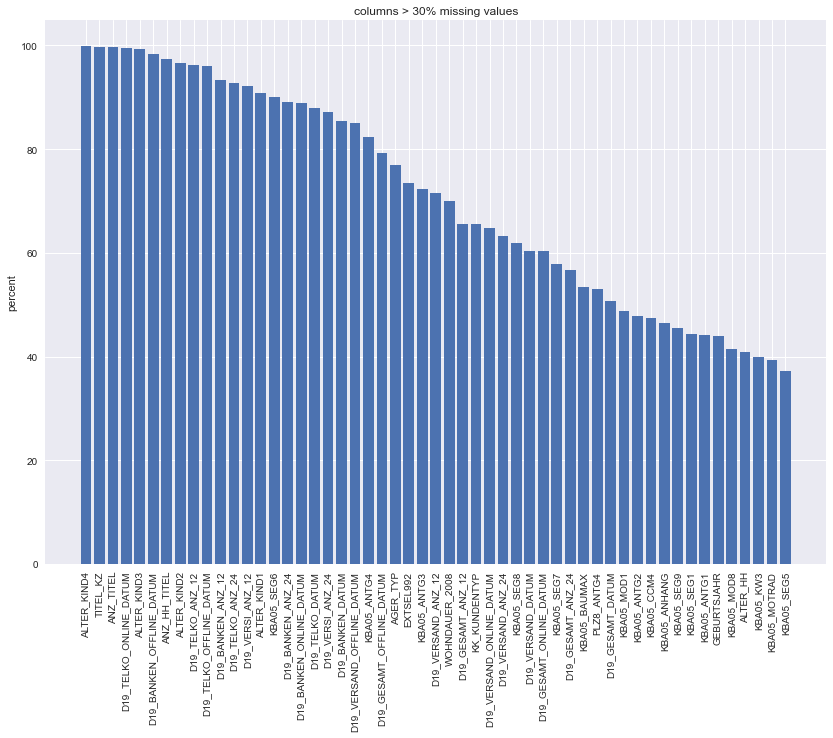

In [103]:
#plot for columns with missing values > 30%
plt.figure(figsize=(14,10))
plt.bar(missing_vals.index, missing_vals.percent, align='center')
plt.ylabel('percent')
plt.xticks(rotation='vertical')
plt.title('columns > 30% missing values')
plt.show();

## Data cleaning steps: dropping columns with > 30 % NAN

In [104]:
#list for columns with > 30% NAN
cols_drop = missing_vals.index.tolist()
print(cols_drop)

['ALTER_KIND4', 'TITEL_KZ', 'ANZ_TITEL', 'D19_TELKO_ONLINE_DATUM', 'ALTER_KIND3', 'D19_BANKEN_OFFLINE_DATUM', 'ANZ_HH_TITEL', 'ALTER_KIND2', 'D19_TELKO_ANZ_12', 'D19_TELKO_OFFLINE_DATUM', 'D19_BANKEN_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_VERSI_ANZ_12', 'ALTER_KIND1', 'KBA05_SEG6', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_ONLINE_DATUM', 'D19_TELKO_DATUM', 'D19_VERSI_ANZ_24', 'D19_BANKEN_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'KBA05_ANTG4', 'D19_GESAMT_OFFLINE_DATUM', 'AGER_TYP', 'EXTSEL992', 'KBA05_ANTG3', 'D19_VERSAND_ANZ_12', 'WOHNDAUER_2008', 'D19_GESAMT_ANZ_12', 'KK_KUNDENTYP', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ANZ_24', 'KBA05_SEG8', 'D19_VERSAND_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'KBA05_SEG7', 'D19_GESAMT_ANZ_24', 'KBA05_BAUMAX', 'PLZ8_ANTG4', 'D19_GESAMT_DATUM', 'KBA05_MOD1', 'KBA05_ANTG2', 'KBA05_CCM4', 'KBA05_ANHANG', 'KBA05_SEG9', 'KBA05_SEG1', 'KBA05_ANTG1', 'GEBURTSJAHR', 'KBA05_MOD8', 'ALTER_HH', 'KBA05_KW3', 'KBA05_MOTRAD', 'KBA05_SEG5']


In [105]:
print('Shape of general population dataframe:', azdias.shape)

Shape of general population dataframe: (891221, 365)


In [106]:
#dropping columns with more than 30% missing values
azdias.drop(cols_drop,axis=1,inplace=True)
print(azdias.shape)

(891221, 312)


In [107]:
#Dropping blank rows
azdias = azdias.dropna(how='all')
#checking dataframe shape
print(azdias.shape)

(891221, 312)


## Inspecting any duplicate data

In [108]:
#No duplicate data indentified
azdias[azdias.duplicated()]

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEU_2015,...,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB


In [109]:
#verifying if all people are unique
azdias.LNR.is_unique

True

## Imputing data

In [110]:
#original numerical cols list
num_cols = ['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','GEBURTSJAHR','KBA13_ANZAHL_PKW','MIN_GEBAEUDEJAHR']
#updated numerical cols list
num_cols_updated = list(set(num_cols).difference(set(cols_drop))) 

In [111]:
%%time
#based upon distribution of numerical columns in parir-plot, imputing numerical data with median 
#imputing data with most frequent value for caegorical(nominal,ordinal) data
imputer_mode = SimpleImputer(strategy='most_frequent')
imputer_median = SimpleImputer(strategy='median')

imputer_mode.fit(azdias.loc[:,~azdias.columns.isin(num_cols_updated)])
azdias.loc[:,~azdias.columns.isin(num_cols_updated)] = imputer_mode.transform(azdias.loc[:,~azdias.columns.isin(num_cols_updated)])

imputer_median.fit(azdias.loc[:,num_cols_updated])
azdias.loc[:,num_cols_updated] = imputer_median.transform(azdias.loc[:,num_cols_updated])

azdias.head()


Wall time: 30min 7s


,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEU_2015,...,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,1.0,15.0,4.0,0.0,1.0,1.0,4.0,6.0,6B,...,0.0,2.0,10.0,10.0,10.0,6.0,3.0,3,1,2.0
1,910220,9.0,21.0,11.0,0.0,2.0,12.0,3.0,6.0,8A,...,0.0,4.0,8.0,11.0,10.0,3.0,4.0,5,2,1.0
2,910225,9.0,17.0,10.0,0.0,1.0,7.0,3.0,2.0,4C,...,0.0,2.0,9.0,9.0,6.0,3.0,2.0,5,2,3.0
3,910226,1.0,13.0,1.0,0.0,1.0,2.0,2.0,4.0,2A,...,1.0,0.0,7.0,10.0,11.0,6.0,7.0,3,2,4.0
4,910241,1.0,14.0,3.0,0.0,4.0,3.0,4.0,2.0,6B,...,0.0,2.0,3.0,5.0,4.0,2.0,3.0,4,1,3.0


In [112]:
#Checking null values  
azdias.isnull().sum().sum()

0

In [113]:
# Rechecking any duplicate data - No duplicate data indentified
azdias[azdias.duplicated()]

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEU_2015,...,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB


In [114]:
#Re-verifying if all people are unique
azdias.LNR.is_unique

True

In [115]:
#dropping any columns with all '0' values and inspecting if there is any change to the shape
azdias = azdias.loc[:, (azdias != 0).any(axis=0)]
print(azdias.shape)

(891221, 312)


## Encoding dummy variables

In [116]:
%%time
#Attempt to improve model, dropping the below two columns
#Encoding dummy variables for CAMEO_DEU_2015
azdias = pd.get_dummies(azdias, prefix='CAMEO_DEU_2015', columns=['CAMEO_DEU_2015'],drop_first=True)

#Encoding dummy variables for D19_LETZTER_KAUF_BRANCHE
azdias = pd.get_dummies(azdias, columns=['D19_LETZTER_KAUF_BRANCHE'], prefix='LETZTER_KAUF_BRANCHE', drop_first=True)

#Replacing 'W','O' with 1 and 0 in OST_WEST_KZ
azdias['OST_WEST_KZ'].replace(to_replace=['W','O'], value=[1,0],inplace=True)

#general population data shape
azdias.shape


Wall time: 8.44 s


(891221, 387)

## Saving clean general population data

In [117]:
#Saving data-frame to file
azdias.to_csv('azdias_clean.csv',index=False)

## Cleaning customer data

In [118]:
# To keep the features consistent between general population and customers, similar steps have been applied to customer data.
#Inspecting the three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP') in "CUSTOMERS" file
customers[['CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP']]

,CUSTOMER_GROUP,ONLINE_PURCHASE,PRODUCT_GROUP
0,MULTI_BUYER,0,COSMETIC_AND_FOOD
1,SINGLE_BUYER,0,FOOD
2,MULTI_BUYER,0,COSMETIC_AND_FOOD
3,MULTI_BUYER,0,COSMETIC
4,MULTI_BUYER,0,FOOD
...,...,...,...
191647,MULTI_BUYER,0,COSMETIC_AND_FOOD
191648,SINGLE_BUYER,0,COSMETIC
191649,MULTI_BUYER,0,COSMETIC_AND_FOOD
191650,SINGLE_BUYER,0,FOOD


In [119]:
#Checking if they contain any null values
customers[['CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP']].isnull().sum()

CUSTOMER_GROUP     0
ONLINE_PURCHASE    0
PRODUCT_GROUP      0
dtype: int64

In [120]:
#Replacing column specific values for unknowns to NaN using missingval_cols from attributes file
col_list_customers = customers.columns.tolist()         #list of customers columns
cols_updated_customers = list(set(missingval_cols).intersection(set(col_list_customers)))  
customers.loc[:,cols_updated_customers] = customers.loc[:,cols_updated_customers].replace(to_replace=[0,0.0,-1,-1.0,9,9.0,10,10.0], value= np.nan)
#Inspecting the data
customers.iloc[1:10,:]

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,9628,NaN,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,3,FOOD,SINGLE_BUYER,0,1,4.0
2,143872,NaN,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,NaN,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4.0
3,143873,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,NaN,7.0,1,COSMETIC,MULTI_BUYER,0,1,4.0
4,143874,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,NaN,3.0,1,FOOD,MULTI_BUYER,0,1,3.0
5,143888,1.0,1.0,11.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,6.0,NaN,1.0,2,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3.0
6,143904,2.0,1.0,NaN,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,NaN,7.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4.0
7,143910,1.0,1.0,NaN,NaN,NaN,NaN,NaN,9.0,1.0,...,1.0,6.0,NaN,3.0,3,FOOD,SINGLE_BUYER,0,1,4.0
8,102160,2.0,3.0,5.0,NaN,NaN,NaN,NaN,4.0,74.0,...,9.0,6.0,3.0,4.0,3,COSMETIC,MULTI_BUYER,0,2,4.0
9,102173,1.0,1.0,20.0,NaN,NaN,NaN,NaN,13.0,1.0,...,4.0,2.0,NaN,5.0,1,COSMETIC,MULTI_BUYER,0,1,3.0


In [121]:
#Replacing 0 with np.nan for numerical columns
num_cols = ['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','GEBURTSJAHR','KBA13_ANZAHL_PKW','MIN_GEBAEUDEJAHR']
customers.loc[:,num_cols] = customers.loc[:,num_cols].replace(to_replace=[0,0.0], value= np.nan)
customers[num_cols].iloc[0:10,:]

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,GEBURTSJAHR,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR
0,1.0,NaN,2.0,NaN,NaN,1201.0,1992.0
1,NaN,NaN,3.0,NaN,NaN,NaN,NaN
2,1.0,NaN,1.0,NaN,NaN,433.0,1992.0
3,NaN,NaN,NaN,NaN,NaN,755.0,1992.0
4,7.0,NaN,4.0,NaN,1960.0,513.0,1992.0
5,1.0,NaN,2.0,NaN,NaN,1167.0,1992.0
6,1.0,NaN,2.0,NaN,1942.0,1300.0,1992.0
7,1.0,NaN,2.0,NaN,1938.0,481.0,1992.0
8,74.0,2.0,1.0,NaN,1914.0,428.0,1994.0
9,1.0,NaN,3.0,NaN,1959.0,1106.0,1997.0


In [122]:
%%time
#Inspecting and cleaning obj data type columns

# replace XX to NAN for CAMEO_DEU_2015
customers['CAMEO_DEU_2015'].replace(to_replace=['XX'], value= np.nan, inplace=True)

# replace X to nan for CAMEO_DEUG_2015 and changing data type to numeric
customers['CAMEO_DEUG_2015'].replace(to_replace=['X'], value= np.nan, inplace=True)
customers['CAMEO_DEUG_2015'] = customers['CAMEO_DEUG_2015'].apply(pd.to_numeric, errors='coerce')

# replace X to nan and changing data type to numeric for CAMEO_INTL_2015
customers['CAMEO_INTL_2015'].replace(to_replace=['XX'], value= np.nan, inplace=True)
customers['CAMEO_INTL_2015'] = customers['CAMEO_INTL_2015'].apply(pd.to_numeric, errors='coerce')

# dropping EINGEFUEGT_AM
customers.drop('EINGEFUEGT_AM',axis=1,inplace=True)

# Replacing any 0.0 in LP_FAMILIE_GROB with np.nan
customers.loc[:,'LP_FAMILIE_GROB'] = customers.loc[:,'LP_FAMILIE_GROB'].replace(to_replace=[0.0], value= np.nan)

Wall time: 6.97 s


In [123]:
print('Shape of customers data:', customers.shape)

Shape of customers data: (191652, 368)


In [124]:
# To keep columns consistent, dropping the same columns which were dropped in general population data
# with more than 30% missing values
customers.drop(cols_drop,axis=1,inplace=True)
print(customers.shape)

(191652, 315)


In [125]:
#Dropping rows with all NAN
customers = customers.dropna(how='all')
#checking dataframe shape
print(customers.shape)

(191652, 315)


In [126]:
#No duplicate data indentified
customers[customers.duplicated()]

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEU_2015,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB


In [127]:
#verifying if all customers # are unique
customers.LNR.is_unique

True

In [128]:
%%time
#Using mode/median imputers to impute categorical and numerical data using same imputers

cust_desc_cols = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP']       # customer description columns
num_cols_cust_cols = list(set(cust_desc_cols).union(set(num_cols_updated)))  #column list to not impute with mode

customers.loc[:,~customers.columns.isin(num_cols_cust_cols)] = imputer_mode.transform(customers.loc[:,~customers.columns.isin(num_cols_cust_cols)])

customers.loc[:,num_cols_updated] = imputer_median.transform(customers.loc[:,num_cols_updated])

customers.head()

Wall time: 15.4 s


,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEU_2015,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,1.0,10.0,1.0,0.0,2.0,1.0,1.0,3.0,1A,...,3.0,2.0,6.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4.0
1,9628,9.0,15.0,4.0,0.0,3.0,1.0,4.0,6.0,6B,...,6.0,3.0,6.0,3.0,3,FOOD,SINGLE_BUYER,0,1,4.0
2,143872,1.0,0.0,1.0,0.0,1.0,1.0,3.0,7.0,5D,...,13.0,11.0,6.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4.0
3,143873,1.0,8.0,4.0,0.0,1.0,1.0,1.0,7.0,4C,...,4.0,2.0,6.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4.0
4,143874,1.0,14.0,7.0,0.0,4.0,7.0,3.0,3.0,7B,...,5.0,4.0,2.0,3.0,1,FOOD,MULTI_BUYER,0,1,3.0


In [129]:
#Checking null values
customers.isnull().sum().sum()

0

In [130]:
#dropping any columns with all '0' values and inspecting if there is any change to the shape
customers = customers.loc[:, (customers != 0).any(axis=0)]
print(customers.shape)

(191652, 315)


In [131]:
#Re-checking any duplicate data - No duplicate data indentified
customers[customers.duplicated()]

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEU_2015,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB


In [132]:
#Re-verifying if all customers # are unique
customers.LNR.is_unique

True

In [133]:
#Encoding dummy variables

#Encoding dummy variables for CAMEO_DEU_2015
customers = pd.get_dummies(customers, prefix='CAMEO_DEU_2015', columns=['CAMEO_DEU_2015'],drop_first=True)

#Encoding dummy variables for D19_LETZTER_KAUF_BRANCHE
customers = pd.get_dummies(customers, columns=['D19_LETZTER_KAUF_BRANCHE'], prefix='LETZTER_KAUF_BRANCHE', drop_first=True)

#Replacing 'W','O' with 1 and 0 in OST_WEST_KZ
customers['OST_WEST_KZ'].replace(to_replace=['W','O'], value=[1,0],inplace=True)

In [134]:
#customers shape, which should be 3 greater than azdias columns
customers.shape

(191652, 390)

In [135]:
#verifying columns are same for azdias and customers except the three columns from cust_desc_cols
set(customers.columns).difference(set(azdias.columns)) 

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [136]:
#Saving data-frame to file
customers.to_csv('customers_clean.csv',index=False)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [5]:
#reading csv files and inspecting the data frames
azdias_clean = pd.read_csv('azdias_clean.csv')
customers_clean = pd.read_csv('customers_clean.csv')

azdias_clean.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,...,LETZTER_KAUF_BRANCHE_D19_SONSTIGE,LETZTER_KAUF_BRANCHE_D19_TECHNIK,LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,LETZTER_KAUF_BRANCHE_D19_TELKO_REST,LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST
0,910215,1.0,15.0,4.0,0.0,1.0,1.0,4.0,6.0,8.0,...,0,0,0,0,0,1,0,0,0,0
1,910220,9.0,21.0,11.0,0.0,2.0,12.0,3.0,6.0,8.0,...,0,0,0,0,0,1,0,0,0,0
2,910225,9.0,17.0,10.0,0.0,1.0,7.0,3.0,2.0,4.0,...,0,0,0,0,0,1,0,0,0,0
3,910226,1.0,13.0,1.0,0.0,1.0,2.0,2.0,4.0,2.0,...,0,0,0,0,0,1,0,0,0,0
4,910241,1.0,14.0,3.0,0.0,4.0,3.0,4.0,2.0,6.0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
customers_clean.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,...,LETZTER_KAUF_BRANCHE_D19_SONSTIGE,LETZTER_KAUF_BRANCHE_D19_TECHNIK,LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,LETZTER_KAUF_BRANCHE_D19_TELKO_REST,LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST
0,9626,1.0,10.0,1.0,0.0,2.0,1.0,1.0,3.0,1.0,...,0,0,0,0,0,1,0,0,0,0
1,9628,9.0,15.0,4.0,0.0,3.0,1.0,4.0,6.0,8.0,...,0,0,0,0,0,0,0,0,0,0
2,143872,1.0,0.0,1.0,0.0,1.0,1.0,3.0,7.0,5.0,...,0,0,0,0,0,1,0,0,0,0
3,143873,1.0,8.0,4.0,0.0,1.0,1.0,1.0,7.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4,143874,1.0,14.0,7.0,0.0,4.0,7.0,3.0,3.0,7.0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Apply feature scaling to general population data
scaler = StandardScaler()
azdias_scaled =  scaler.fit_transform(azdias_clean.iloc[:,1:])     # dropping first col as it is for customer identity
azdias_scaled = pd.DataFrame(azdias_scaled, columns = azdias_clean.columns[1:])
azdias_scaled.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,...,LETZTER_KAUF_BRANCHE_D19_SONSTIGE,LETZTER_KAUF_BRANCHE_D19_TECHNIK,LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,LETZTER_KAUF_BRANCHE_D19_TELKO_REST,LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST
0,-0.869634,0.212708,-0.260739,-0.292527,-0.651197,-0.430981,0.755697,0.771572,0.927216,0.977331,...,-0.229852,-0.088988,-0.128365,-0.114193,-0.053861,0.984765,-0.173466,-0.263188,-0.201615,-0.049336
1,1.346190,1.606082,0.211104,-0.292527,0.271316,0.371236,-0.263623,0.771572,0.927216,0.977331,...,-0.229852,-0.088988,-0.128365,-0.114193,-0.053861,0.984765,-0.173466,-0.263188,-0.201615,-0.049336
2,1.346190,0.677166,0.143698,-0.292527,-0.651197,0.006592,-0.263623,-1.095860,-0.729265,-0.937974,...,-0.229852,-0.088988,-0.128365,-0.114193,-0.053861,0.984765,-0.173466,-0.263188,-0.201615,-0.049336
3,-0.869634,-0.251750,-0.462957,-0.292527,-0.651197,-0.358052,-1.282942,-0.162144,-1.557505,-1.789221,...,-0.229852,-0.088988,-0.128365,-0.114193,-0.053861,0.984765,-0.173466,-0.263188,-0.201615,-0.049336
4,-0.869634,-0.019521,-0.328145,-0.292527,2.116342,-0.285123,0.755697,-1.095860,0.098976,0.409833,...,-0.229852,-0.088988,-0.128365,-0.114193,-0.053861,-1.015471,-0.173466,-0.263188,-0.201615,-0.049336


In [9]:
%%time
#Applying PCA to general population data
pca = PCA(n_components=None, random_state=10)
pca.fit(azdias_scaled)

Wall time: 48.5 s


PCA(random_state=10)

In [10]:
# Computing and printing the amount of variance that each PC explains, top twenty PC shown here 
var = pca.explained_variance_ratio_
print('PC variance ratio in descending order: \n', np.around(var[0:20],decimals = 3))

PC variance ratio in descending order: 
 [0.067 0.044 0.037 0.033 0.022 0.018 0.017 0.016 0.014 0.013 0.013 0.011
 0.01  0.009 0.009 0.008 0.008 0.008 0.007 0.007]


In [11]:
# Printing the captured cumulative variance 
var_azdias = np.cumsum(np.around(var, decimals = 4))*100
print('PC variance in percent:\n',var_azdias)

PC variance in percent:
 [ 6.73 11.15 14.89 18.23 20.46 22.25 23.93 25.52 26.91 28.23 29.48 30.59
 31.56 32.45 33.33 34.15 34.93 35.71 36.45 37.18 37.85 38.52 39.13 39.73
 40.3  40.86 41.41 41.94 42.46 42.96 43.45 43.94 44.41 44.88 45.34 45.78
 46.22 46.64 47.05 47.46 47.86 48.26 48.65 49.03 49.4  49.76 50.12 50.47
 50.82 51.17 51.51 51.84 52.17 52.5  52.82 53.14 53.46 53.78 54.09 54.4
 54.7  55.   55.3  55.6  55.89 56.18 56.47 56.76 57.05 57.34 57.62 57.9
 58.18 58.46 58.74 59.02 59.3  59.58 59.86 60.13 60.4  60.67 60.94 61.21
 61.48 61.75 62.02 62.29 62.56 62.83 63.1  63.37 63.64 63.91 64.18 64.45
 64.72 64.99 65.25 65.51 65.77 66.03 66.29 66.55 66.81 67.07 67.33 67.59
 67.85 68.11 68.37 68.63 68.89 69.15 69.41 69.67 69.93 70.19 70.45 70.71
 70.97 71.23 71.49 71.75 72.01 72.27 72.53 72.79 73.04 73.29 73.54 73.79
 74.04 74.29 74.53 74.77 75.01 75.25 75.49 75.73 75.97 76.2  76.43 76.66
 76.89 77.12 77.34 77.56 77.78 78.   78.22 78.44 78.66 78.88 79.1  79.31
 79.52 79.73 79.94 80.15 80.

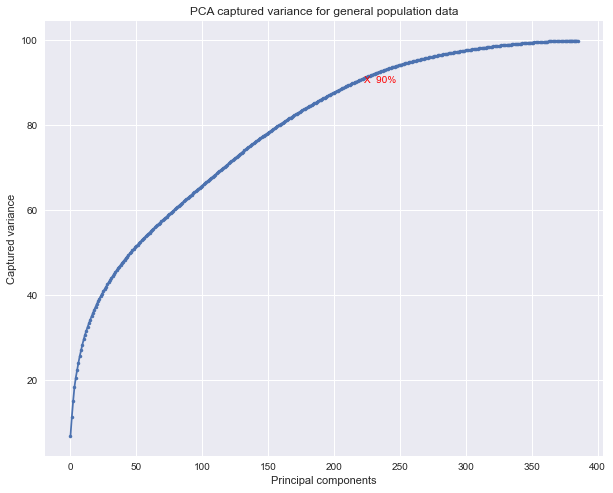

In [12]:
# Visualising captured variance with respect to increasing latent dimensionality
plt.figure(figsize=(10,8))
plt.plot(var_azdias, marker = '.') 
plt.annotate('X  90%',(223,90), color='red')
plt.xlabel('Principal components')
plt.ylabel('Captured variance')
plt.title('PCA captured variance for general population data');

In [13]:
#First 223 dimensions capture approx. 90% variance 
var_azdias[var_azdias < 91.0].shape

(223,)

In [14]:
#Reducing the dimensions to 223
pca = PCA(n_components = 223,random_state=10)
azdias_pca = pca.fit_transform(azdias_scaled) 
#viewing the shape of the data
azdias_pca.shape

(891221, 223)

In [15]:
%%time
#Applying K-means clustering to general population data


# Constructing the elbow method graph by appending sum of squared distances of data points to their closest cluster (intertia)

totSqrdDist=[]         # passing an empty list

K = range(1,20)        # Setting cluster range from 1 to 20

for i in K:
    kmeans = KMeans(n_clusters = i, random_state=0)
    kmeans = kmeans.fit(azdias_pca)
    totSqrdDist.append(kmeans.inertia_)    

sqdist = np.array(np.around(totSqrdDist,2))

print('Sum of squared distances in descending order: \n')
print(sqdist)


Sum of squared distances in descending order: 

[3.12609204e+08 2.96022984e+08 2.88714637e+08 2.83148374e+08
 2.78100894e+08 2.74118228e+08 2.70703668e+08 2.68126165e+08
 2.65844613e+08 2.64121046e+08 2.62704071e+08 2.61375645e+08
 2.60355158e+08 2.59416682e+08 2.58397048e+08 2.57736913e+08
 2.56948717e+08 2.56122928e+08 2.55187019e+08]
Wall time: 1h 10min 27s


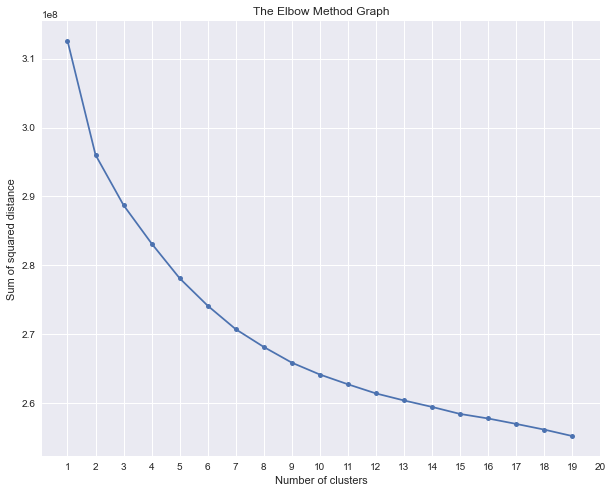

In [16]:
# Plotting the elbow graph  
plt.figure(figsize=(10,8))
plt.plot(K,totSqrdDist, marker = '.', markersize = 10)
xtic = np.arange(1,21)
plt.xticks(xtic)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distance');

From the elbow method graph and the sum of squared distance figures, ten clusters appears to be ideal as the subsequent reducing steps (after 2.64e+08) are in closer proximity of each other that previous steps. 

In [17]:
# Performing K-means clustering using ten clusters and printing the K-means outputs and the centroids
k = 10
kmeans_model = KMeans(n_clusters = k, random_state=0)
kmeans_model.fit(azdias_pca)                      
print('Kmeans output:\n', kmeans_model)
print()
centroids = kmeans_model.cluster_centers_     # cluster centroids
print('Centroids for ten clusters:\n', pd.DataFrame(centroids))


Kmeans output:
 KMeans(n_clusters=10, random_state=0)

Centroids for ten clusters:
         0         1         2         3         4         5         6    \
0 -2.973408  0.172480 -1.392953 -5.347705  1.492757  3.132332 -0.416661   
1  6.332375 -0.856526  3.513745  1.789674 -0.660124  0.767624 -0.341358   
2 -5.709730  5.301763  0.816679  2.882328 -0.249789 -1.636529 -1.153394   
3  4.030551  6.288049 -1.412704  1.592904  1.519715  0.353571  1.104341   
4  4.697389 -0.690835 -3.210412 -1.524499 -1.567576 -1.027452 -0.559760   
5 -6.705719 -0.947193  3.096485  1.245547 -1.976174 -0.155507 -0.319928   
6 -0.146306  0.803766  2.681644 -3.272020  0.088274 -0.587652  0.712177   
7 -1.980232  0.313010 -3.648582  1.297562 -1.417232  0.673614  0.112546   
8 -5.375611 -5.523065 -1.271329  3.571856  3.712350 -0.577640  0.712704   
9  2.689553 -7.012770 -0.841664  0.362457  2.667194 -1.695255  0.163808   

        7         8         9    ...       213       214       215       216  \
0 -2.38873

In [18]:
#Predicting the closest cluster for each sample for general population 
azdias_pred = kmeans_model.predict(azdias_pca)
azdias_pred[0:20]    #printing first 20 values

array([0, 6, 6, 4, 1, 4, 6, 6, 3, 3, 7, 0, 3, 6, 0, 7, 6, 0, 6, 3])

In [19]:
#Dataframe for general population cluster prediction
azdias_cluster = pd.DataFrame(azdias_pred)
#Adding column for clusters in azdias_clean using the predicted cluster values
azdias_clean['CLUSTER'] = azdias_cluster
#Saving data-frame with cluster information to file
azdias_clean.to_csv('azdias_clean_clustered.csv',index=False)

In [20]:
# Applying scaling, PCA and Kmeans clustering to customer data without'CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP'
# and 'LNR' 

# Apply feature scaling to customer data
cust_desc_cols = ['LNR','CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP']       # customer description columns & LNR
customers_trim = customers_clean.loc[:,~customers_clean.columns.isin(cust_desc_cols)]
customers_scaled = scaler.transform(customers_trim)
                                     
#Reducing to the dimensions as per general population data
customers_pca = pca.transform(customers_scaled)  
#viewing the shape of the data
customers_pca.shape

(191652, 223)

In [21]:
%%time
# Performing K-means clustering using ten clusters on customer data and printing the K-means outputs and the centroids
kmeans_model.fit(customers_pca)                       
print('Kmeans output: \n', kmeans_model)
print()
centroids = kmeans_model.cluster_centers_     # cluster centroids
print('Centroids for the ten clusters:\n', pd.DataFrame(centroids))


Kmeans output: 
 KMeans(n_clusters=10, random_state=0)

Centroids for the ten clusters:
         0         1         2         3         4         5         6    \
0  7.816018 -2.874739 -0.902966  0.637348 -1.816212 -1.375276 -1.600414   
1 -3.039690  0.189487 -1.596035 -5.620442  1.565544  3.162972 -0.329628   
2  7.351566  0.554607  0.571442  4.528151 -0.456730  0.652810  0.442643   
3 -2.517095  0.829883 -2.457834  4.620203 -0.818269  0.369986 -0.242522   
4  6.937467  5.947573 -2.572585  4.024381  0.953331 -0.037163  1.371390   
5  5.297616  1.641600 -2.042295  3.651636 -0.566970  0.309680  0.329527   
6  5.086901  2.299604 -2.310854  4.212704 -0.302902 -0.309685  0.696957   
7  5.296596  7.451340 -2.919591  3.922564  1.314030 -0.335983  1.074086   
8  4.470324  1.630695 -2.425425  3.282458 -0.537881  0.144763  0.072031   
9  4.293929  0.657652 -4.165683  1.333489 -0.902361 -0.479988  0.861964   

        7         8         9    ...       213       214       215       216  \
0 -0.

In [22]:
#Predicting the closest cluster for each sample for customers data
customers_pred = kmeans_model.predict(customers_pca)
customers_pred[0:20] #printing first 20 values

array([9, 3, 3, 9, 2, 7, 0, 7, 3, 2, 3, 9, 0, 2, 3, 2, 7, 2, 3, 9])

In [23]:
#Dataframe for customers cluster prediction
customers_cluster = pd.DataFrame(customers_pred)
#Adding column for clusters in customers_clean using the above predictions
customers_clean['CLUSTER'] = customers_cluster
#Saving data-frame with cluster information to file
customers_clean.to_csv('customers_clean_clustered.csv',index=False)

In [24]:
#Reading general population and customers data sets with cluster column
azdias_clean = pd.read_csv('azdias_clean_clustered.csv')
customers_clean = pd.read_csv('customers_clean_clustered.csv')

In [25]:
#plotting difference between cluster proportions of the two data sets.
# azdias cluster proportions
az_cluster_percent = (azdias_clean.CLUSTER.value_counts() / azdias_clean.shape[0])*100
az_cluster_percent.name = 'general_population'
# customers cluster proportions
cust_cluster_percent = (customers_clean.CLUSTER.value_counts() / customers_clean.shape[0])*100
cust_cluster_percent.name = 'customer_population'

In [26]:
#calculating the difference between proportions and merging the series to a data frame
difference =   cust_cluster_percent - az_cluster_percent
difference.name = 'Difference'
cluster_df = pd.merge(az_cluster_percent, cust_cluster_percent,left_index=True, right_index=True)
cluster_df = pd.merge(cluster_df, difference,left_index=True, right_index=True)
cluster_df.sort_values(by='Difference',ascending=False,inplace=True)
#plotting the difference in proportions
cluster_df.style.bar(subset=difference.name, align='mid', color=['#d65f5f', '#5fba7d'])

,general_population,customer_population,Difference
9,6.318859,19.079373,12.760514
1,13.603135,24.545530,10.942395
2,7.319397,15.119592,7.800195
3,8.405659,13.353370,4.947710
0,8.632876,11.609062,2.976187
7,12.741733,10.647423,-2.094310
8,6.361161,0.421597,-5.939563
5,9.781412,2.785778,-6.995634
4,12.260483,1.695260,-10.565223
6,14.575285,0.743013,-13.832272


In [27]:
# variance_ratio_ for pca components by features
pca_var_ratio = pd.DataFrame(np.round(pca.components_,2), columns=azdias_scaled.columns)
pca_var_ratio.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,...,LETZTER_KAUF_BRANCHE_D19_SONSTIGE,LETZTER_KAUF_BRANCHE_D19_TECHNIK,LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,LETZTER_KAUF_BRANCHE_D19_TELKO_REST,LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST
0,-0.06,-0.03,-0.08,0.03,0.09,-0.07,-0.10,0.05,-0.14,-0.14,...,0.01,0.01,0.00,0.00,0.01,-0.09,0.01,0.03,0.02,0.01
1,0.02,-0.00,0.02,-0.01,-0.02,0.02,-0.04,-0.08,-0.02,-0.02,...,0.01,-0.00,-0.00,-0.00,-0.00,0.02,-0.00,-0.01,-0.01,0.00
2,0.03,0.16,-0.00,0.09,0.08,-0.00,-0.02,-0.02,-0.00,-0.01,...,0.00,0.01,0.01,0.00,0.01,-0.10,0.03,0.02,0.01,-0.00
3,-0.05,-0.06,0.05,0.03,0.10,0.06,0.05,-0.10,0.01,0.01,...,0.03,0.01,0.01,0.01,0.01,-0.14,0.02,0.03,0.04,0.01
4,-0.00,0.03,-0.00,0.00,-0.01,-0.00,0.10,0.04,-0.01,0.00,...,-0.01,-0.00,-0.00,-0.00,-0.00,0.01,-0.00,-0.00,0.00,-0.00


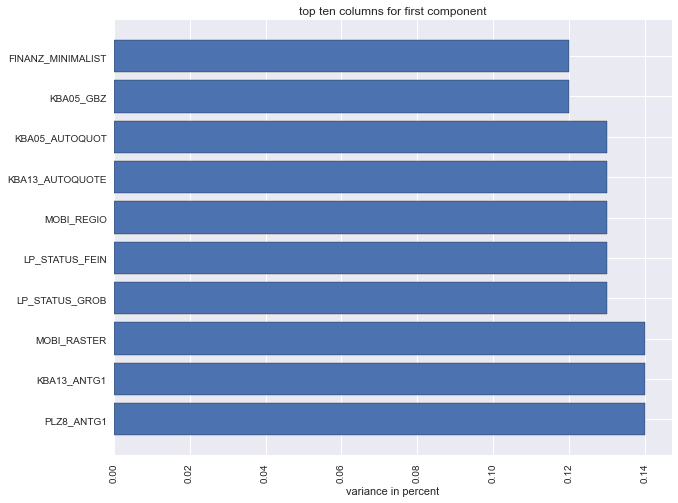

In [28]:
#plot for top ten features by explained variance for the first component
first_comp = pca_var_ratio.iloc[0].sort_values(ascending=False)[0:10]
plt.figure(figsize=(10,8))
plt.barh(first_comp.keys(),first_comp.values, edgecolor='black')
plt.xlabel('variance in percent')
plt.xticks(rotation='vertical')
plt.title('top ten columns for first component') 
plt.show();

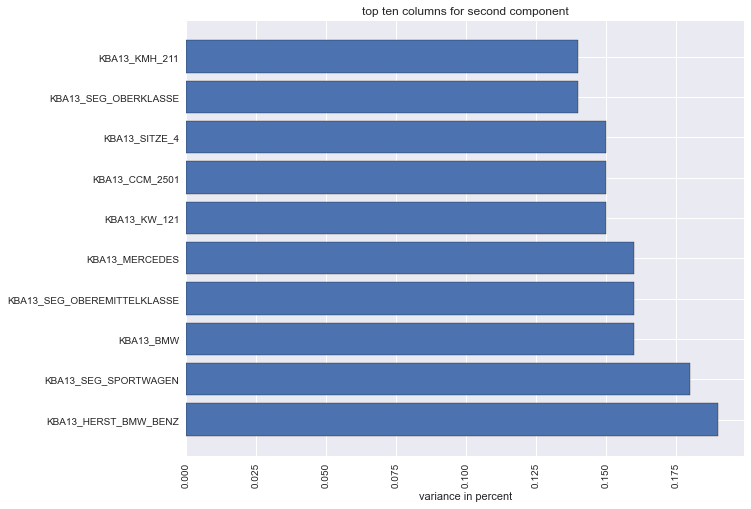

In [29]:
# plot for top ten features by explained variance for the second component
sec_comp = pca_var_ratio.iloc[1].sort_values(ascending=False)[0:10]
plt.figure(figsize=(10,8))
plt.barh(sec_comp.keys(),sec_comp.values, edgecolor='black')
plt.xlabel('variance in percent')
plt.xticks(rotation='vertical')
plt.title('top ten columns for second component') 
plt.show();

In [30]:
#Over-represented cluster is cluster ten
print('Count:',len(customers_clean.query('CLUSTER == 9')))
print()
print(pd.DataFrame(customers_clean.query('CLUSTER == 9')['CUSTOMER_GROUP'].value_counts()/customers_clean.shape[0]*100))
print()
print(pd.DataFrame(customers_clean.query('CLUSTER == 9')['ONLINE_PURCHASE'].value_counts()/customers_clean.shape[0]*100))
print()
print(pd.DataFrame(customers_clean.query('CLUSTER == 9')['PRODUCT_GROUP'].value_counts()/customers_clean.shape[0]*100))

Count: 36566

              CUSTOMER_GROUP
MULTI_BUYER        14.276397
SINGLE_BUYER        4.802976

   ONLINE_PURCHASE
0        18.275312
1         0.804062

                   PRODUCT_GROUP
COSMETIC_AND_FOOD      11.265210
FOOD                    4.041701
COSMETIC                3.772463


In [31]:
#Most under-respresented cluster is cluster seven
print('Count:',len(customers_clean.query('CLUSTER == 6')))
print()
print(pd.DataFrame(customers_clean.query('CLUSTER == 6')['CUSTOMER_GROUP'].value_counts()/customers_clean.shape[0]*100))
print()
print(pd.DataFrame(customers_clean.query('CLUSTER == 6')['ONLINE_PURCHASE'].value_counts()/customers_clean.shape[0]*100))
print()
print(pd.DataFrame(customers_clean.query('CLUSTER == 6')['PRODUCT_GROUP'].value_counts()/customers_clean.shape[0]*100))

Count: 1424

              CUSTOMER_GROUP
MULTI_BUYER         0.525953
SINGLE_BUYER        0.217060

   ONLINE_PURCHASE
0         0.685618
1         0.057396

                   PRODUCT_GROUP
COSMETIC_AND_FOOD       0.392900
COSMETIC                0.192536
FOOD                    0.157577


Cluster 10, which is the most over-represented cluster has a count of 36,566. Of all customers, cluster 10 customers who are multi-buyer and single buyer are 14.3% and 4.8% respectively. Cluster 10 customers who have shopped and not shopped online represent 0.8% and 18.3% of the customer population. Cluster 10 customers who have purchased cosmetic and food, food and cosmetic represent 11.3%, 4% and 3.8% of the customer population.

Cluster 7, which is the most under-represented cluster has a count of 1424. Of all customers, cluster 7 customers who are multi-buyer and single buyer are 0.5% and 0.2% respectively. Cluster 7 customers who have shopped and not shopped online represent 0.05% and 0.7% of the customer population. Cluster 4 customers who have purchased cosmetic and food, food and cosmetic represent 0.4%, 0.2% and 0.15% of the customer population. These figures indicate a signficant difference between the size and representation of these two clusters.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [74]:
#Reading the data
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Users\Administrator\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [75]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [76]:
#checking shape
mailout_train.shape

(42962, 367)

In [77]:
%%time
# Data cleaning steps
mailout_train = clean_data(mailout_train)
mailout_train, cols_drop = drop_null_cols_vals(mailout_train)

#updated numerical cols list
num_cols = ['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','GEBURTSJAHR','KBA13_ANZAHL_PKW','MIN_GEBAEUDEJAHR']
num_cols_updated = list(set(num_cols).difference(set(cols_drop))) 

#new col list by adding RESPONSE column to num_cols_updated to avoid any imputation on it
updated_list = num_cols_updated.copy()
updated_list.append('RESPONSE')

imputer_mode = SimpleImputer(strategy='most_frequent')
imputer_median = SimpleImputer(strategy='median')

#imputing data with most frequent value for caegorical(nominal,ordinal) data
imputer_mode.fit(mailout_train.loc[:,~mailout_train.columns.isin(updated_list)])
mailout_train.loc[:,~mailout_train.columns.isin(updated_list)] = imputer_mode.transform(mailout_train.loc[:,~mailout_train.columns.isin(updated_list)])

#imputing numerical data with median 
imputer_median.fit(mailout_train.loc[:,num_cols_updated])
mailout_train.loc[:,num_cols_updated] = imputer_median.transform(mailout_train.loc[:,num_cols_updated])

#encode categorical variables with dummies
mailout_train = encode_cat_vars(mailout_train)

#Saving data-frame to file
mailout_train.to_csv('mailout_train.csv',index=False)

Wall time: 22.3 s


In [78]:
#Loading mailout_train_clean data
mailout_train_clean = pd.read_csv('mailout_train.csv')

In [79]:
mailout_train_clean.shape

(42962, 294)

In [80]:
mailout_train_clean.isna().sum().sum()

0

In [81]:
mailout_train_clean.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,1.0,8.0,15.0,0.0,1.0,13.0,3.0,5.0,5.0,...,2.0,5.0,2.0,1.0,6.0,3.0,3,0,2,4.0
1,1771,4.0,13.0,1.0,0.0,2.0,1.0,2.0,5.0,5.0,...,3.0,1.0,2.0,1.0,4.0,7.0,1,0,2,3.0
2,1776,1.0,7.0,2.0,0.0,2.0,1.0,4.0,1.0,2.0,...,1.0,6.0,4.0,2.0,6.0,2.0,3,0,1,4.0
3,1460,1.0,6.0,4.0,0.0,2.0,4.0,4.0,2.0,2.0,...,4.0,8.0,11.0,11.0,6.0,1.0,3,0,2,4.0
4,1783,1.0,9.0,53.0,0.0,1.0,44.0,3.0,4.0,7.0,...,4.0,2.0,2.0,1.0,6.0,3.0,3,0,1,3.0


no_response count: 42430   response count: 532
no_response proportion: 0.99 response proportion: 0.01


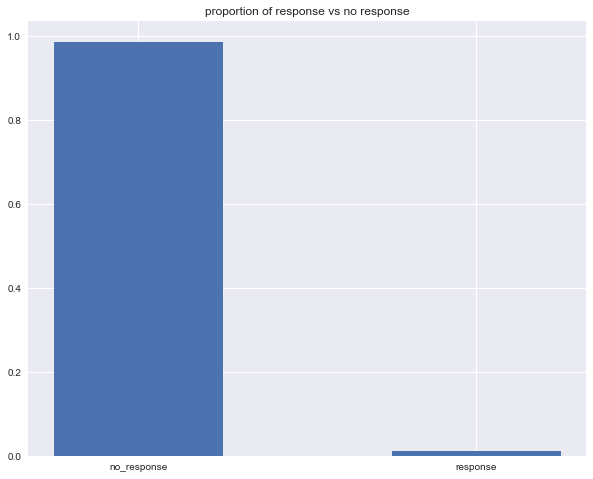

In [53]:
#plotting proportions of response vs no response in the test set
print('no_response count:',mailout_train.RESPONSE.value_counts()[0], '  response count:',mailout_train.RESPONSE.value_counts()[1])
print('no_response proportion:', np.round(mailout_train.RESPONSE.value_counts()[0]/mailout_train.shape[0],2),
      'response proportion:', np.round(mailout_train.RESPONSE.value_counts()[1]/mailout_train.shape[0],2))
val_prop = list(mailout_train.RESPONSE.value_counts()/mailout_train.shape[0])
names = ['no_response','response']
plt.figure(figsize=(10,8))
plt.bar(names, val_prop, width=0.5)
plt.title('proportion of response vs no response');

In [54]:
# Getting X, y from load_data()
X,y = load_data()

# Perform train test split on X,y
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3)

In [67]:
%%time
#Building Guassian Naive Bayes, AdaBoost, Random Forest and Logistic regression classifiers without any 
#hyperparameter tuning/scaling and reporting auc_score

#Guassian Naive Bayes 
GNB_clf = GaussianNB()
GNB_clf.fit(X_train, y_train)
ypred_GNB = GNB_clf.predict(X_test)

print('Gaussian Navie Bayes classifier:\n F1-score:', np.round(f1_score(y_test,ypred_GNB),2),'\n ROC_AUC score:', 
      np.round(roc_auc_score(y_test,ypred_GNB),2))
print()

#Ada Boost
ADB_clf = AdaBoostClassifier(random_state=0)
ADB_clf.fit(X_train, y_train)
ypred_ADB = ADB_clf.predict(X_test)

print('AdaBoost classifier:\n F1-score:', np.round(f1_score(y_test,ypred_ADB),2),'\n ROC_AUC score:', 
      np.round(roc_auc_score(y_test,ypred_ADB),2))
print()

#Random Forest
RF_clf = RandomForestClassifier(random_state=0)
RF_clf.fit(X_train, y_train)
ypred_RF = RF_clf.predict(X_test)

print('Random Forest classifier:\n F1-score:', np.round(f1_score(y_test,ypred_RF),2),'\n ROC_AUC score:', 
      np.round(roc_auc_score(y_test,ypred_RF),2))
print()


#Logistic regression
LR_clf = LogisticRegression(random_state=0)
LR_clf.fit(X_train, y_train)
ypred_LR = LR_clf.predict(X_test)

print('Logistic Regression classifier:\n F1-score:', np.round(f1_score(y_test,ypred_LR),2),'\n ROC_AUC score:', 
      np.round(roc_auc_score(y_test,ypred_LR),2))
print()



Gaussian Navie Bayes classifier:
 F1-score: 0.04 
 ROC_AUC score: 0.59

AdaBoost classifier:
 F1-score: 0.0 
 ROC_AUC score: 0.5

Random Forest classifier:
 F1-score: 0.0 
 ROC_AUC score: 0.5

Logistic Regression classifier:
 F1-score: 0.0 
 ROC_AUC score: 0.5

Wall time: 1min 11s


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [88]:
# Building a pipeline and declaring hyper-parameter range

#Guassian Naive Bayes 
pipeline_nb = Pipeline([('scaler',StandardScaler()),
                        ('nb',GaussianNB())])
grid_param_nb = {}

#Ada Boost
pipeline_ab = Pipeline([('scaler',StandardScaler()),
                        ('ab',AdaBoostClassifier(random_state=10))])

grid_param_ab = {
    'ab__n_estimators': [50,75],
    'ab__learning_rate':[0.05,0.1,0.3,0.5] 
}

#Random Forest
pipeline_rf = Pipeline([('scaler', StandardScaler()),
                         ('rf',RandomForestClassifier(class_weight='balanced', random_state=10))])
                     
grid_param_rf = {
    'rf__n_estimators' :[150,200,250],
    'rf__min_samples_split': [3,4,5],
    'rf__min_samples_leaf': [3,4,5,6],
    'rf__ccp_alpha': [0.005,0.007,0.01,0.03]
}


#Logistic regression
from sklearn.linear_model import LogisticRegression

pipeline_lr = Pipeline([('scaler',StandardScaler()),
                        ('lr',LogisticRegression(random_state=10))])

grid_param_lr = {
    'lr__penalty': ['elasticnet'],
    'lr__solver':['saga'],
    'lr__class_weight':['balanced'],
    'lr__C':[0.5,1.0,1.5],
    'lr__l1_ratio':[0.25,0.5,1.0]
}


In [89]:
#Grid search function
def gscv(pipeline, grid_param, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    
    '''
    INPUT: pipeline, parameters for pipeline, training and testing sets
            
    OUTPUT: returns the best model, grid search report and model evaluation report
    
    Description: GridSearchCV uses the pipeline, parameters with scoring of roc_auc to pass an object.
    The object is fitted to training set wherby it scales the training data and uses cross
    validation to  build best model. It then fits the model to the test set and returns the model and predictions. 
    
    '''

    # Using grid search to find best parameters for a pipeline
    cv = GridSearchCV(pipeline, grid_param, scoring = 'roc_auc', cv=8, verbose=0, n_jobs=-1)
    
    # Training the best grid search classifier 
    cv.fit(X_train,y_train)

    # Predict on test data using the best parameters
    y_pred = cv.predict(X_test)
   
    return cv,y_pred

In [90]:
#Model evaluation function
def model_eval(cv,y_pred, X_test=X_test,y_test=y_test):
    
    '''
    INPUT: best grid search model, training and testing sets, predictions
            
    OUTPUT: prints the model evaluation report,class report, confusion matrix and roc curve. 
    
    Description: The function uses the model, predictions and the test sets to print the model evaluation report,
    class report, confusion matrix and roc curve. 
    
    '''
    
    #printing estimator and best parameters
    print()
    print('*****Grid Search report*****')
    print('.'*80)
    
    #printing estimator information
    print('Pipeline:\n', cv.best_estimator_)
    print('.'*80)
    print()
    
    #printing best parameters
    print('Best parameters:', cv.best_params_)
    print('.'*80)
    print()
    
    #printing best auc score
    print('Auc score:', np.round(cv.best_score_,2))
    print('.'*80)
    print()
    
    # Evaluating the model
    class_report = classification_report(y_test, y_pred)
    
    #printing model evaluation report
    print('*****Model evaluation report*****')
    print('.'*80)
    #printing class report
    print('Class report: \n', class_report)
    print('.'*80)
    print()
    
    #printing confusion matrix
    #Confusion matrix
    conf_matrix = confusion_matrix(y_test,y_pred)
    index = ['No response (0)','Response (1)']
    columns = ['No response (0)','Response (1)']
    cm_df = pd.DataFrame(conf_matrix, columns, index)                  
    sns.heatmap(cm_df,annot=True, cmap='Blues',fmt='g')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.plot()
    
    #plotting roc curve
    plot_roc_curve(cv, X_test, y_test)
    plt.title('ROC Curve')
    plt.show()
   


In [142]:
# Checking pipeline_rf hyperparameters
pipeline_rf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'rf', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'rf__bootstrap', 'rf__ccp_alpha', 'rf__class_weight', 'rf__criterion', 'rf__max_depth', 'rf__max_features', 'rf__max_leaf_nodes', 'rf__max_samples', 'rf__min_impurity_decrease', 'rf__min_impurity_split', 'rf__min_samples_leaf', 'rf__min_samples_split', 'rf__min_weight_fraction_leaf', 'rf__n_estimators', 'rf__n_jobs', 'rf__oob_score', 'rf__random_state', 'rf__verbose', 'rf__warm_start'])

In [143]:
# Checking pipeline_ab hyperparameters
pipeline_ab.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'ab', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'ab__algorithm', 'ab__base_estimator', 'ab__learning_rate', 'ab__n_estimators', 'ab__random_state'])

In [144]:
# Checking pipeline_nb hyperparameters
pipeline_nb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'nb', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'nb__priors', 'nb__var_smoothing'])

In [145]:
# Checking pipeline_lr hyperparameters
pipeline_lr.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'lr', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'lr__C', 'lr__class_weight', 'lr__dual', 'lr__fit_intercept', 'lr__intercept_scaling', 'lr__l1_ratio', 'lr__max_iter', 'lr__multi_class', 'lr__n_jobs', 'lr__penalty', 'lr__random_state', 'lr__solver', 'lr__tol', 'lr__verbose', 'lr__warm_start'])

In [93]:
%%time
#Gaussian Naive Bayes Classifier 
cv_nb, ypred_nb = gscv(pipeline_nb,grid_param_nb)
cv_nb

Wall time: 2.63 s


GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('nb', GaussianNB())]),
             n_jobs=-1, param_grid={}, scoring='roc_auc')


*****Grid Search report*****
................................................................................
Pipeline:
 Pipeline(steps=[('scaler', StandardScaler()), ('nb', GaussianNB())])
................................................................................

Best parameters: {}
................................................................................

Auc score: 0.63
................................................................................

*****Model evaluation report*****
................................................................................
Class report: 
               precision    recall  f1-score   support

           0       0.99      0.37      0.54     12727
           1       0.01      0.71      0.03       162

    accuracy                           0.38     12889
   macro avg       0.50      0.54      0.28     12889
weighted avg       0.98      0.38      0.53     12889

.....................................................................

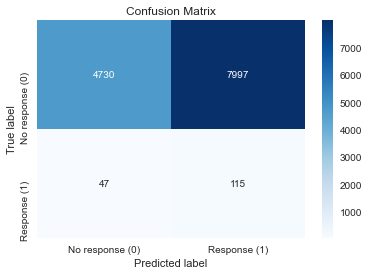

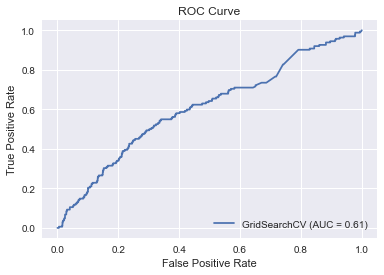

Wall time: 468 ms


In [94]:
%%time
#Naive Bayes Classifier model evaluation
model_eval(cv_nb, y_pred=ypred_nb)

In [91]:
%%time
#Random Forest Classifier
cv_rf, ypred_rf = gscv(pipeline_rf,grid_param_rf)
cv_rf

Wall time: 1h 19min 47s


GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=10))]),
             n_jobs=-1,
             param_grid={'rf__ccp_alpha': [0.005, 0.007, 0.01, 0.03],
                         'rf__min_samples_leaf': [3, 4, 5, 6],
                         'rf__min_samples_split': [3, 4, 5],
                         'rf__n_estimators': [150, 200, 250]},
             scoring='roc_auc')


*****Grid Search report*****
................................................................................
Pipeline:
 Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(ccp_alpha=0.005,
                                        class_weight='balanced',
                                        min_samples_leaf=4, min_samples_split=3,
                                        n_estimators=250, random_state=10))])
................................................................................

Best parameters: {'rf__ccp_alpha': 0.005, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 3, 'rf__n_estimators': 250}
................................................................................

Auc score: 0.74
................................................................................

*****Model evaluation report*****
................................................................................
Class report: 
              

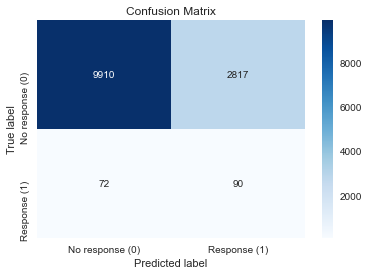

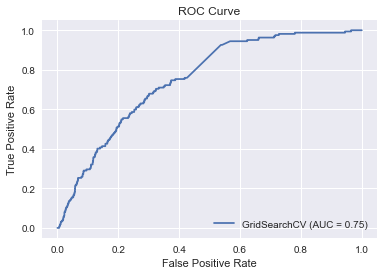

Wall time: 637 ms


In [92]:
%%time
#Random Forest Classifier model evaluation
model_eval(cv_rf, y_pred=ypred_rf)

In [95]:
%%time
#AdaBoost Classifier
cv_ab, ypred_ab = gscv(pipeline_ab,grid_param_ab)
cv_ab

Wall time: 6min 30s


GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ab',
                                        AdaBoostClassifier(random_state=10))]),
             n_jobs=-1,
             param_grid={'ab__learning_rate': [0.05, 0.1, 0.3, 0.5],
                         'ab__n_estimators': [50, 75]},
             scoring='roc_auc')


*****Grid Search report*****
................................................................................
Pipeline:
 Pipeline(steps=[('scaler', StandardScaler()),
                ('ab',
                 AdaBoostClassifier(learning_rate=0.05, n_estimators=75,
                                    random_state=10))])
................................................................................

Best parameters: {'ab__learning_rate': 0.05, 'ab__n_estimators': 75}
................................................................................

Auc score: 0.76
................................................................................

*****Model evaluation report*****
................................................................................
Class report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     12727
           1       0.00      0.00      0.00       162

    accuracy                           0.99     12889


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


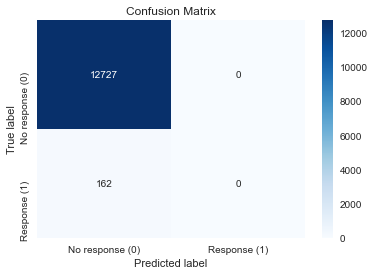

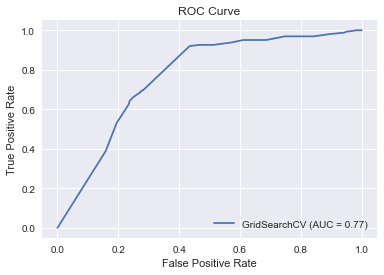

Wall time: 1.37 s


In [96]:
%%time
#Adaboost Classifier model evaluation
model_eval(cv_ab, y_pred=ypred_ab)

In [97]:
%%time
#Logistic Regression Classifier 
cv_lr, ypred_lr = gscv(pipeline_lr,grid_param_lr)
cv_lr

Wall time: 5min 15s


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(random_state=10))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.5, 1.0, 1.5],
                         'lr__class_weight': ['balanced'],
                         'lr__l1_ratio': [0.25, 0.5, 1.0],
                         'lr__penalty': ['elasticnet'],
                         'lr__solver': ['saga']},
             scoring='roc_auc')


*****Grid Search report*****
................................................................................
Pipeline:
 Pipeline(steps=[('scaler', StandardScaler()),
                ('lr',
                 LogisticRegression(class_weight='balanced', l1_ratio=0.5,
                                    penalty='elasticnet', random_state=10,
                                    solver='saga'))])
................................................................................

Best parameters: {'lr__C': 1.0, 'lr__class_weight': 'balanced', 'lr__l1_ratio': 0.5, 'lr__penalty': 'elasticnet', 'lr__solver': 'saga'}
................................................................................

Auc score: 0.61
................................................................................

*****Model evaluation report*****
................................................................................
Class report: 
               precision    recall  f1-score   support

           0       0.

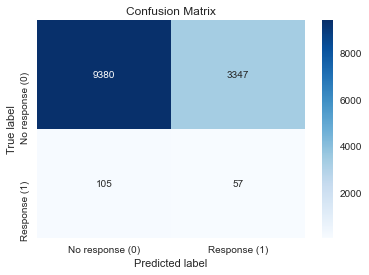

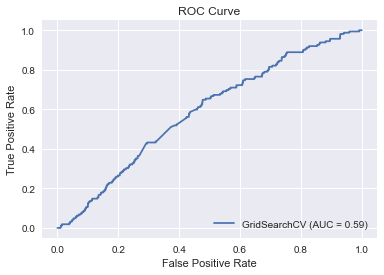

Wall time: 422 ms


In [98]:
%%time
#Logistic Regression Classifier model evaluation
model_eval(cv_lr, y_pred=ypred_lr)

In [231]:
%%time
#attempt to improve random forest model (dropping cols with 20% NAN, features dropped to 226)
#change the drop_null_cols_vals function for this cell to run correctly
#Random Forest Classifier
cv_rf2, ypred_rf2 = gscv(pipeline_rf,grid_param_rf)
cv_rf2

Wall time: 1h 20min 17s


GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=10))]),
             n_jobs=-1,
             param_grid={'rf__ccp_alpha': [0.005, 0.007, 0.01, 0.03],
                         'rf__min_samples_leaf': [3, 4, 5, 6],
                         'rf__min_samples_split': [3, 4, 5],
                         'rf__n_estimators': [150, 200, 250]},
             scoring='roc_auc')

*****Grid Search report*****
................................................................................
Pipeline:
 Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(ccp_alpha=0.01, class_weight='balanced',
                                        min_samples_leaf=3, min_samples_split=3,
                                        n_estimators=150, random_state=10))])
................................................................................

Best parameters: {'rf__ccp_alpha': 0.01, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 3, 'rf__n_estimators': 150}
................................................................................

Auc score: 0.74
................................................................................

*****Model evaluation report*****
................................................................................
Class report: 
               precision    recall  f1-score   support

 

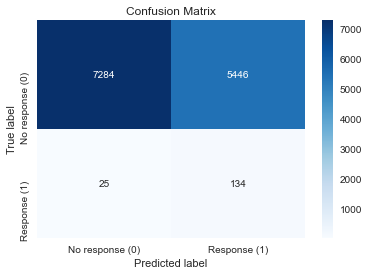

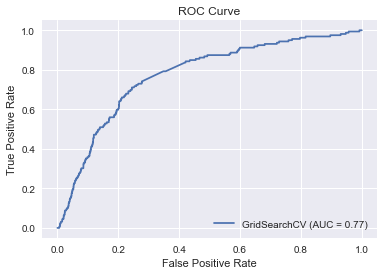

Wall time: 702 ms


In [232]:
%%time
#Random Forest Classifier model evaluation , with reduced columns
model_eval(cv_rf2, y_pred=ypred_rf2)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [99]:
#Reading the data
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\Administrator\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [100]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [101]:
%%time
# Data cleaning steps
#Peforming data cleaning and dropping cols/rows
mailout_test = clean_data(mailout_test)

# Dropping the same columns which were dropped in mailout_train  with more than 30% missing values
# Not dropping any rows to meet Kaggle competition requirements of prediction for each customers
mailout_test.drop(cols_drop,axis=1,inplace=True)
    
#Using mode/median imputers to impute categorical and numerical data using same imputers from training set
mailout_test.loc[:,~mailout_test.columns.isin(num_cols_updated)] = imputer_mode.transform(mailout_test.loc[:,~mailout_test.columns.isin(num_cols_updated)])
mailout_test.loc[:,num_cols_updated] = imputer_median.transform(mailout_test.loc[:,num_cols_updated])

#encode categorical variables with dummies
mailout_test = encode_cat_vars(mailout_test)

#Saving data-frame to file
mailout_test.to_csv('mailout_test.csv',index=False)


Wall time: 14.9 s


In [102]:
#Reading mailout_test cleaned data
mailout_test_clean = pd.read_csv('mailout_test.csv')
mailout_test_clean.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,...,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,1.0,6.0,2.0,0.0,2.0,2.0,3.0,6.0,2.0,...,1.0,4.0,5.0,6.0,3.0,6.0,3.0,3,1,4.0
1,1770,1.0,0.0,20.0,0.0,1.0,21.0,4.0,7.0,5.0,...,1.0,1.0,5.0,2.0,1.0,6.0,5.0,3,1,4.0
2,1465,9.0,11.0,2.0,0.0,4.0,2.0,4.0,1.0,7.0,...,1.0,3.0,9.0,6.0,3.0,2.0,4.0,3,2,4.0
3,1470,7.0,0.0,1.0,0.0,2.0,1.0,4.0,1.0,2.0,...,1.0,2.0,6.0,6.0,3.0,6.0,2.0,3,2,4.0
4,1478,1.0,13.0,1.0,0.0,4.0,1.0,3.0,6.0,5.0,...,1.0,1.0,2.0,4.0,3.0,3.0,7.0,4,2,4.0


In [103]:
#printing shape and checking null values
print('shape:', mailout_test.shape)
print('total null values:',mailout_test.isna().sum().sum())

shape: (42833, 293)
total null values: 0


In [104]:
#removing LNR column and running the best model
y_mailout = mailout_test.drop(['LNR'], axis=1).copy().values

#Running the best model (Random Forest) to make predictions
y_pred_mailout = cv_rf.predict(y_mailout)
y_pred_mailout[0:20]  #printing first 20 predictions

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1],
      dtype=int64)

In [105]:
#Prediction probability
y_pred_prob = cv_ab.predict_proba(y_mailout)
y_pred_prob

array([[0.72949949, 0.27050051],
       [0.72157703, 0.27842297],
       [0.8046677 , 0.1953323 ],
       ...,
       [0.72257959, 0.27742041],
       [0.75946566, 0.24053434],
       [0.72949949, 0.27050051]])

In [106]:
#printing probabilities for positive class
y_pred_prob[:,1]

array([0.27050051, 0.27842297, 0.1953323 , ..., 0.27742041, 0.24053434,
       0.27050051])

In [107]:
#Preparing csv file for competition submission
#Dataframe for prediction probability of positive class
pred_prob = pd.DataFrame(y_pred_prob[:,1])
#Adding column for response probabilities using the above predictions
mailout_test_clean['RESPONSE'] = pred_prob
#Saving data-frame with LNR and RESPONSE columns to file
mailout_test_clean[['LNR','RESPONSE']].to_csv('mailout_test_response.csv',index=False)

In [108]:
#Reading and checking mailout_test_response 
mailout_test_response = pd.read_csv('mailout_test_response.csv')
mailout_test_response.head()

,LNR,RESPONSE
0,1754,0.270501
1,1770,0.278423
2,1465,0.195332
3,1470,0.189922
4,1478,0.216216
